In [111]:
#importing Pandas for Data manipulation
import pandas as pd

In [112]:
#Reading training data from csv file and storing in a variable
df = pd.read_csv("train_set.csv", encoding='latin-1')

In [113]:
#printing the 1st five rows
df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [114]:
#importing modules for data cleaning
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [115]:
#Defining regular expressions for removing unnecessay symbols, if any
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

#Defining Stopwords to remove them from our data
STOPWORDS = set(stopwords.words('english'))

In [116]:
#Defining a function for cleaning the text data from training set
def clean_text(text):
    
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace symbols defined above(if any) by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE defined above from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [117]:
#Applying text cleaning on our training data
df['text'] = df['text'].apply(clean_text)

In [118]:
#Seperating Data into Training and Test Set
from sklearn.model_selection import train_test_split

X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [119]:
#Preparing data for training
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Applying CountVectorizer to tokenize the text documents
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(X_train)

#Applying TfidfTransformer to learn the vocabulary and inverse document frequency weightings
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

In [120]:
#Using different Classifiers for training
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Storing different models in a list
models = [
    ('NB',MultinomialNB()),
    ('SVM',SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=0, max_iter=5, tol=None)),
    ('LR',LogisticRegression(n_jobs=1, C=1e5)),
    ('DT',DecisionTreeClassifier()),
    ('kNN',KNeighborsClassifier()),
    ('RF',RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)),
]


In [121]:
from sklearn import model_selection

results = []
names = []
print("Accuracy of different classifiers during Cross Validation")

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

Accuracy of different classifiers during Cross Validation
NB: 0.885299
SVM: 0.860375
LR: 0.927707
DT: 0.907683
kNN: 0.882819
RF: 0.483303


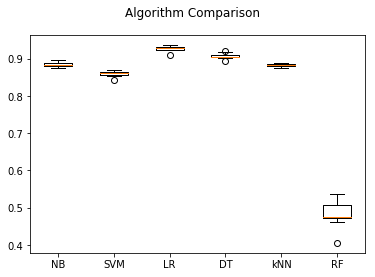

In [122]:
#Compare Algorithms
from matplotlib import pyplot as plt

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [123]:
#Using LSTM for training on Neural Network
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, SpatialDropout1D, Embedding
from keras.preprocessing import text, sequence

from keras import utils

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 32
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13850 unique tokens.


In [124]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (23615, 32)


In [125]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (23615, 12)


In [126]:
from sklearn.model_selection import train_test_split

X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train_lstm.shape,Y_train_lstm.shape)
print(X_test_lstm.shape,Y_test_lstm.shape)

(16530, 32) (16530, 12)
(7085, 32) (7085, 12)


In [127]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 32

history = model.fit(X_train_lstm, Y_train_lstm, epochs=epochs, batch_size=batch_size,validation_split=0.1)

accr = model.evaluate(X_test_lstm,Y_test_lstm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

# serialize model to JSON
model_json = model.to_json()
with open("model_lstm.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model_lstm.h5")
print("Saved model to disk")

#This training was done on Google Colab due to hardware constraints on local machine, and the output of training is pasted below

Train on 14877 samples, validate on 1653 samples
Epoch 1/100
14877/14877 [==============================] - 46s 3ms/step - loss: 1.0577 - acc: 0.6499 - val_loss: 0.5453 - val_acc: 0.8294
Epoch 2/100
14877/14877 [==============================] - 41s 3ms/step - loss: 0.4451 - acc: 0.8542 - val_loss: 0.4052 - val_acc: 0.8609
Epoch 3/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.3538 - acc: 0.8814 - val_loss: 0.3440 - val_acc: 0.8887
Epoch 4/100
14877/14877 [==============================] - 41s 3ms/step - loss: 0.3056 - acc: 0.8994 - val_loss: 0.3414 - val_acc: 0.8869
Epoch 5/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.2798 - acc: 0.9055 - val_loss: 0.3141 - val_acc: 0.8972
Epoch 6/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.2558 - acc: 0.9139 - val_loss: 0.3188 - val_acc: 0.8935
Epoch 7/100
14877/14877 [==============================] - 41s 3ms/step - loss: 0.2331 - acc: 0.9184 - val_loss: 0.3239 - val_acc: 0.8941
Epoch 8/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.2218 - acc: 0.9244 - val_loss: 0.3306 - val_acc: 0.8966
Epoch 9/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.2114 - acc: 0.9251 - val_loss: 0.3202 - val_acc: 0.8966
Epoch 10/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.2010 - acc: 0.9313 - val_loss: 0.3265 - val_acc: 0.8984
Epoch 11/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1915 - acc: 0.9316 - val_loss: 0.3153 - val_acc: 0.9044
Epoch 12/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1812 - acc: 0.9371 - val_loss: 0.3339 - val_acc: 0.8941
Epoch 13/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1746 - acc: 0.9374 - val_loss: 0.3185 - val_acc: 0.9014
Epoch 14/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1652 - acc: 0.9422 - val_loss: 0.3299 - val_acc: 0.9002
Epoch 15/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1602 - acc: 0.9425 - val_loss: 0.3398 - val_acc: 0.8996
Epoch 16/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1546 - acc: 0.9461 - val_loss: 0.3280 - val_acc: 0.9056
Epoch 17/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1542 - acc: 0.9455 - val_loss: 0.3374 - val_acc: 0.9026
Epoch 18/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1478 - acc: 0.9484 - val_loss: 0.3473 - val_acc: 0.8959
Epoch 19/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1380 - acc: 0.9507 - val_loss: 0.3480 - val_acc: 0.9038
Epoch 20/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1359 - acc: 0.9511 - val_loss: 0.3409 - val_acc: 0.9044
Epoch 21/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1329 - acc: 0.9515 - val_loss: 0.3502 - val_acc: 0.9032
Epoch 22/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1276 - acc: 0.9562 - val_loss: 0.3570 - val_acc: 0.9068
Epoch 23/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1273 - acc: 0.9554 - val_loss: 0.3648 - val_acc: 0.9020
Epoch 24/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1221 - acc: 0.9562 - val_loss: 0.3799 - val_acc: 0.9032
Epoch 25/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1178 - acc: 0.9586 - val_loss: 0.3658 - val_acc: 0.9032
Epoch 26/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1174 - acc: 0.9571 - val_loss: 0.3751 - val_acc: 0.9050
Epoch 27/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1110 - acc: 0.9605 - val_loss: 0.3843 - val_acc: 0.9056
Epoch 28/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.1107 - acc: 0.9596 - val_loss: 0.3761 - val_acc: 0.9002
Epoch 29/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1061 - acc: 0.9613 - val_loss: 0.3857 - val_acc: 0.9056
Epoch 30/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1061 - acc: 0.9620 - val_loss: 0.3753 - val_acc: 0.9062
Epoch 31/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1055 - acc: 0.9616 - val_loss: 0.3922 - val_acc: 0.9080
Epoch 32/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0995 - acc: 0.9638 - val_loss: 0.3862 - val_acc: 0.9068
Epoch 33/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.1020 - acc: 0.9626 - val_loss: 0.4079 - val_acc: 0.9056
Epoch 34/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0985 - acc: 0.9640 - val_loss: 0.3953 - val_acc: 0.9105
Epoch 35/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0985 - acc: 0.9646 - val_loss: 0.4144 - val_acc: 0.9014
Epoch 36/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.1005 - acc: 0.9634 - val_loss: 0.4137 - val_acc: 0.9056
Epoch 37/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0932 - acc: 0.9665 - val_loss: 0.4287 - val_acc: 0.9038
Epoch 38/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0927 - acc: 0.9665 - val_loss: 0.4279 - val_acc: 0.9062
Epoch 39/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0934 - acc: 0.9658 - val_loss: 0.4357 - val_acc: 0.9014
Epoch 40/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0920 - acc: 0.9666 - val_loss: 0.4326 - val_acc: 0.9068
Epoch 41/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0925 - acc: 0.9661 - val_loss: 0.4322 - val_acc: 0.9020
Epoch 42/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0878 - acc: 0.9675 - val_loss: 0.4339 - val_acc: 0.9050
Epoch 43/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0884 - acc: 0.9661 - val_loss: 0.4370 - val_acc: 0.9074
Epoch 44/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0861 - acc: 0.9684 - val_loss: 0.4413 - val_acc: 0.9099
Epoch 45/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0854 - acc: 0.9690 - val_loss: 0.4379 - val_acc: 0.9044
Epoch 46/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0874 - acc: 0.9677 - val_loss: 0.4432 - val_acc: 0.9044
Epoch 47/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0822 - acc: 0.9697 - val_loss: 0.4477 - val_acc: 0.9056
Epoch 48/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0845 - acc: 0.9683 - val_loss: 0.4493 - val_acc: 0.9038
Epoch 49/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0827 - acc: 0.9693 - val_loss: 0.4503 - val_acc: 0.9032
Epoch 50/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0835 - acc: 0.9679 - val_loss: 0.4455 - val_acc: 0.9032
Epoch 51/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0819 - acc: 0.9694 - val_loss: 0.4483 - val_acc: 0.9056
Epoch 52/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0810 - acc: 0.9698 - val_loss: 0.4631 - val_acc: 0.9020
Epoch 53/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0815 - acc: 0.9694 - val_loss: 0.4647 - val_acc: 0.9062
Epoch 54/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0803 - acc: 0.9702 - val_loss: 0.4696 - val_acc: 0.9080
Epoch 55/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0833 - acc: 0.9689 - val_loss: 0.4874 - val_acc: 0.9038
Epoch 56/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0803 - acc: 0.9687 - val_loss: 0.4710 - val_acc: 0.9056
Epoch 57/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0782 - acc: 0.9701 - val_loss: 0.4798 - val_acc: 0.9056
Epoch 58/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0781 - acc: 0.9702 - val_loss: 0.4925 - val_acc: 0.9044
Epoch 59/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0779 - acc: 0.9698 - val_loss: 0.4696 - val_acc: 0.9087
Epoch 60/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0767 - acc: 0.9707 - val_loss: 0.4729 - val_acc: 0.9044
Epoch 61/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0779 - acc: 0.9707 - val_loss: 0.4786 - val_acc: 0.9080
Epoch 62/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0787 - acc: 0.9698 - val_loss: 0.4770 - val_acc: 0.9074
Epoch 63/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0774 - acc: 0.9704 - val_loss: 0.4906 - val_acc: 0.9080
Epoch 64/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0766 - acc: 0.9710 - val_loss: 0.4984 - val_acc: 0.9038
Epoch 65/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0768 - acc: 0.9703 - val_loss: 0.4948 - val_acc: 0.9050
Epoch 66/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0765 - acc: 0.9699 - val_loss: 0.4875 - val_acc: 0.9050
Epoch 67/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0770 - acc: 0.9710 - val_loss: 0.4803 - val_acc: 0.9099
Epoch 68/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0748 - acc: 0.9717 - val_loss: 0.4931 - val_acc: 0.9062
Epoch 69/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0747 - acc: 0.9716 - val_loss: 0.4989 - val_acc: 0.9038
Epoch 70/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0730 - acc: 0.9712 - val_loss: 0.4947 - val_acc: 0.9062
Epoch 71/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0788 - acc: 0.9692 - val_loss: 0.4983 - val_acc: 0.9026
Epoch 72/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0754 - acc: 0.9709 - val_loss: 0.4920 - val_acc: 0.9056
Epoch 73/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0734 - acc: 0.9719 - val_loss: 0.4985 - val_acc: 0.9056
Epoch 74/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0746 - acc: 0.9710 - val_loss: 0.4901 - val_acc: 0.9062
Epoch 75/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0767 - acc: 0.9714 - val_loss: 0.4853 - val_acc: 0.9032
Epoch 76/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0733 - acc: 0.9708 - val_loss: 0.4976 - val_acc: 0.9062
Epoch 77/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0731 - acc: 0.9708 - val_loss: 0.4876 - val_acc: 0.9074
Epoch 78/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0723 - acc: 0.9720 - val_loss: 0.4921 - val_acc: 0.9044
Epoch 79/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0745 - acc: 0.9704 - val_loss: 0.5017 - val_acc: 0.9020
Epoch 80/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0755 - acc: 0.9708 - val_loss: 0.4814 - val_acc: 0.9044
Epoch 81/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0726 - acc: 0.9716 - val_loss: 0.4815 - val_acc: 0.9008
Epoch 82/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0740 - acc: 0.9716 - val_loss: 0.4903 - val_acc: 0.9056
Epoch 83/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0735 - acc: 0.9722 - val_loss: 0.4873 - val_acc: 0.9062
Epoch 84/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0718 - acc: 0.9724 - val_loss: 0.5009 - val_acc: 0.9038
Epoch 85/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0737 - acc: 0.9708 - val_loss: 0.5009 - val_acc: 0.9026
Epoch 86/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0714 - acc: 0.9724 - val_loss: 0.4976 - val_acc: 0.9056
Epoch 87/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0735 - acc: 0.9716 - val_loss: 0.5011 - val_acc: 0.9038
Epoch 88/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0731 - acc: 0.9712 - val_loss: 0.5013 - val_acc: 0.9044
Epoch 89/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0737 - acc: 0.9722 - val_loss: 0.5069 - val_acc: 0.9014
Epoch 90/100
14877/14877 [==============================] - 41s 3ms/step - loss: 0.0714 - acc: 0.9719 - val_loss: 0.4964 - val_acc: 0.9087
Epoch 91/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0713 - acc: 0.9726 - val_loss: 0.5027 - val_acc: 0.9038
Epoch 92/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0732 - acc: 0.9709 - val_loss: 0.5114 - val_acc: 0.9032
Epoch 93/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0735 - acc: 0.9713 - val_loss: 0.5033 - val_acc: 0.9056
Epoch 94/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0715 - acc: 0.9730 - val_loss: 0.5108 - val_acc: 0.9026
Epoch 95/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0709 - acc: 0.9725 - val_loss: 0.5126 - val_acc: 0.9074
Epoch 96/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0733 - acc: 0.9714 - val_loss: 0.4911 - val_acc: 0.9074
Epoch 97/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0718 - acc: 0.9720 - val_loss: 0.4953 - val_acc: 0.9056
Epoch 98/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0707 - acc: 0.9722 - val_loss: 0.5042 - val_acc: 0.9087
Epoch 99/100
14877/14877 [==============================] - 40s 3ms/step - loss: 0.0708 - acc: 0.9710 - val_loss: 0.5168 - val_acc: 0.9038
Epoch 100/100
14877/14877 [==============================] - 39s 3ms/step - loss: 0.0715 - acc: 0.9717 - val_loss: 0.5122 - val_acc: 0.9044
7085/7085 [==============================] - 6s 874us/step
Test set
  Loss: 0.514
  Accuracy: 0.907


Since the Cross Validation score for Logistic Regression Classifier is highest among others(~0.93) including LSTM which has a validation accuracy of 0.907, we use the Logistic Regression Classifier for making predictions on our test set.

First checking the accuracy on the test set splitted form the existing training set in the ratio of Train(70%) and Test(30%). 


In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#Saving the trained model to pickle file 
filename = "logreg_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(logreg, file)

y_pred = logreg.predict(X_test)
acc_lr = accuracy_score(y_pred, y_test)

print('accuracy %s' % acc_lr)


accuracy 0.9338038108680311


The accuracy obtained on test set(0.93) is near to the cross validation score of the Logistic Regression classifier obtained above.


# Using test_set.csv


Now, we test the performance of the Logistic Regression model which gave the highest accuracy among other clasifier on a different test set. i.e., test_set.csv

In [129]:
import pandas as pd

#Reading testing data from csv file and storing in a variable
df_test = pd.read_csv("test_set.csv", encoding='latin-1')

#printing 1st five rows
df_test.head()

,text
0,lv tmd pd trip unit for nh parts of circuit br...
1,module tm analog outputs analog output expansi...
2,command group t iii mechanismt p parts forcir...
3,parts of relayelectrical contact issu e f xxup
4,parts for programmable logic controllers dm ...


In [130]:
#X_test_test stands for test data(text) from test_set
X_test_test = df_test.text

In [131]:
#Making prediction on the test set using the Logistic Regression model trained above
filename = "logreg_model.pkl"
with open(filename, 'rb') as file:
    logreg_model = pickle.load(file)

y_pred = logreg_model.predict(X_test_test)

In [132]:
print(y_pred)

[85389000 85389000 85389000 ... 84713010 84713010 84713010]


In [133]:
list(y_pred)

[85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85369090,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85369090,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 39269099,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85369090,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85369090,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 87089900,
 85389000,
 39269099,
 85389000,
 39269099,
 85389000,
 87089900,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,
 85389000,

These are the final predictions on the test set. 